In [64]:
##  Import Packages
import numpy as np
import pandas as pd
import plotly 
import calendar

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', None) # show all of columns

Identify relevant time-based features in the dataset. Prepare the data for time-series analysis. 

data transformation. 
handling missing values.
feature engineering.

In [65]:
# Load Data
car_sale_df = pd.read_csv('Car_sale_ads.csv')
car_sale_df.head(2) 

,Index,Price,Currency,Condition,Vehicle_brand,Vehicle_model,Vehicle_version,Vehicle_generation,Production_year,Mileage_km,Power_HP,Displacement_cm3,Fuel_type,CO2_emissions,Drive,Transmission,Type,Doors_number,Colour,Origin_country,First_owner,First_registration_date,Offer_publication_date,Offer_location,Features
0,0,86200,PLN,New,Abarth,595,NaN,NaN,2021,1.00,145.00,"1,400.00",Gasoline,NaN,Front wheels,Manual,small_cars,3.00,gray,NaN,NaN,NaN,04/05/2021,"ul. Jubilerska 6 - 04-190 Warszawa, Mazowiecki...",[]
1,1,43500,PLN,Used,Abarth,Other,NaN,NaN,1974,"59,000.00",75.00,"1,100.00",Gasoline,NaN,Front wheels,Manual,coupe,2.00,silver,NaN,NaN,NaN,03/05/2021,"kanonierska12 - 04-425 Warszawa, Rembertów (Po...",[]


In [66]:
car_sale_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208304 entries, 0 to 208303
Data columns (total 25 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Index                    208304 non-null  int64  
 1   Price                    208304 non-null  int64  
 2   Currency                 208304 non-null  object 
 3   Condition                208304 non-null  object 
 4   Vehicle_brand            208304 non-null  object 
 5   Vehicle_model            208304 non-null  object 
 6   Vehicle_version          138082 non-null  object 
 7   Vehicle_generation       147860 non-null  object 
 8   Production_year          208304 non-null  int64  
 9   Mileage_km               207321 non-null  float64
 10  Power_HP                 207661 non-null  float64
 11  Displacement_cm3         206338 non-null  float64
 12  Fuel_type                208304 non-null  object 
 13  CO2_emissions            94047 non-null   float64
 14  Driv

### Data Transformation


In [67]:
# Data Transformation

# 1.Create consistency in price : Convert PLN to EUR
Avg_exchange_rate_2021 = 0.2191 # Average exchange rate in 2021
car_sale_df[(car_sale_df['Currency'] == 'PLN')]['Price']= car_sale_df[car_sale_df['Currency']=='PLN']['Price'] * Avg_exchange_rate_2021


/var/folders/76/1yzscp4d71l1rljcgf5sbbfm0000gn/T/ipykernel_56458/3044473233.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car_sale_df[(car_sale_df['Currency'] == 'PLN')]['Price']= car_sale_df[car_sale_df['Currency']=='PLN']['Price'] * Avg_exchange_rate_2021


In [68]:
#  2. Change Data Type: 'Offer_publication_date' and 'First_registration_date' to Datetime

#Convert Dates to Datetime Format:
for date_column in ["First_registration_date", "Offer_publication_date"]:
    car_sale_df[date_column] = pd.to_datetime(car_sale_df[date_column], errors='coerce', format='%d/%m/%Y')


### Handling Missing Values


In [69]:
# Mileage for New vehicles is typically much lower or even one, compared to Used vehicles. Filling missing values globally (using the overall median) might overestimate or underestimate the mileage for certain categories.
# Fill missing values in Mileage_km based on Condition-specific medians

# Calculate medians for Mileage_km grouped by Condition
mileage_medians = car_sale_df.groupby("Condition")["Mileage_km"].median()

# Fill missing Mileage_km values with the median of their respective Condition group
car_sale_df["Mileage_km"] = car_sale_df["Mileage_km"].fillna(
    car_sale_df["Condition"].map(mileage_medians)
)
# Verify if there are still missing values in Mileage_km
missing_check = car_sale_df["Mileage_km"].isnull().sum()
print(f"Missing values in Mileage_km after imputation: {missing_check}")


Missing values in Mileage_km after imputation: 0


In [70]:
# List of columns where missing values need to be handled with Median
median_imput_col = ['Power_HP','Displacement_cm3']

# Loop through each column in the list
for col in median_imput_col:
    car_sale_df[col] = car_sale_df[col].fillna(car_sale_df[col].median()) # Fill missing values in the column with the Median


for col in median_imput_col:
    # Count the remaining missing values (if any) in the current column
    missing_check = car_sale_df[col].isnull().sum()

    # Print the count of missing values after the imputation process
    print(f"Missing values in {col} after imputation: {missing_check}")


Missing values in Power_HP after imputation: 0
Missing values in Displacement_cm3 after imputation: 0


In [71]:
# List of columns where missing values need to be handled with Mode
car_sale_df['Transmission'] = car_sale_df['Transmission'].fillna(car_sale_df['Transmission'].mode()[0])# Fill missing values in the column with the Mode

### Feature engineering

In [72]:
# # Feature Engineering: Extract time-based features from "Offer_publication_date"

car_sale_df['Offer_month'] = car_sale_df['Offer_publication_date'].dt.month
car_sale_df['Offer_day'] = car_sale_df['Offer_publication_date'].dt.day
car_sale_df['Offer_day_of_week'] = car_sale_df['Offer_publication_date'].dt.dayofweek
car_sale_df['Offer_week'] = car_sale_df['Offer_publication_date'].dt.isocalendar().week


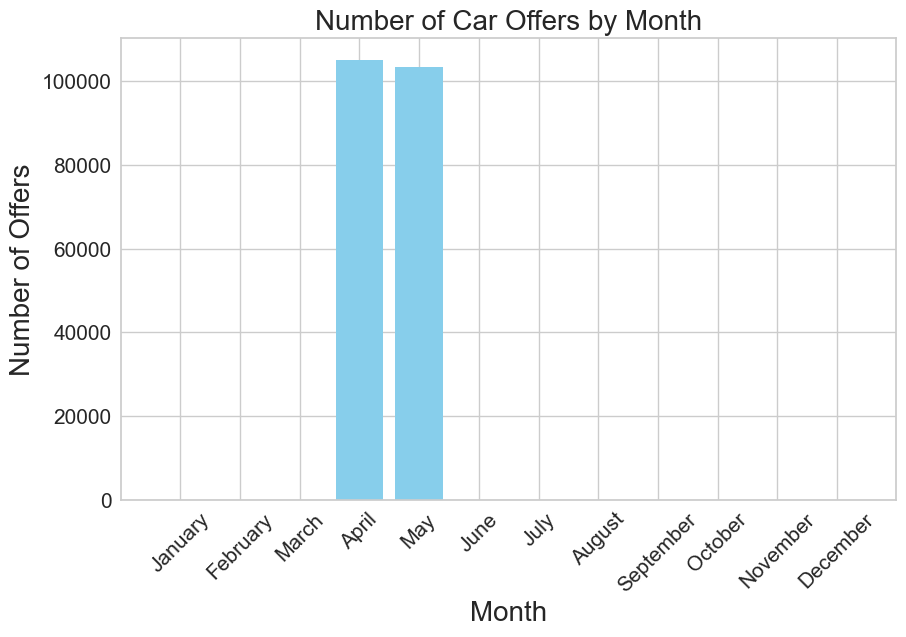

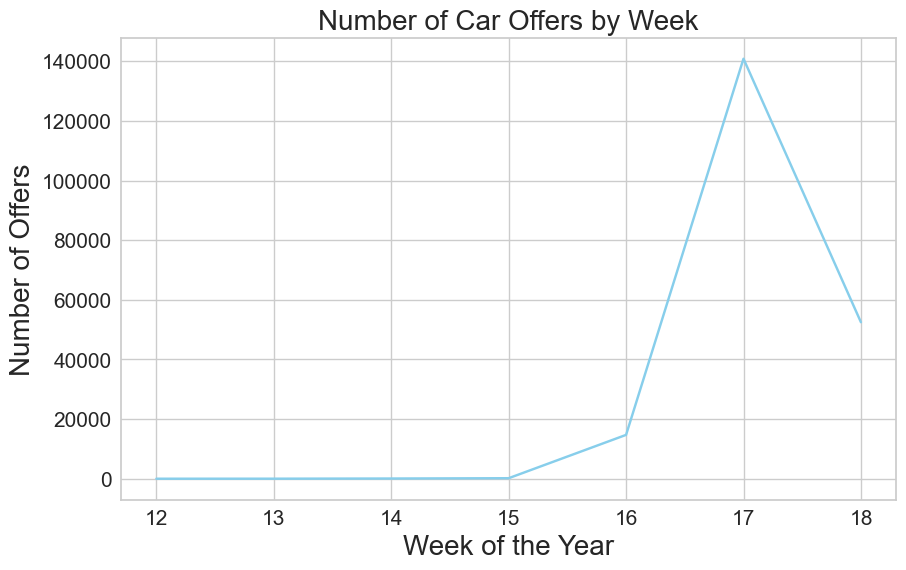

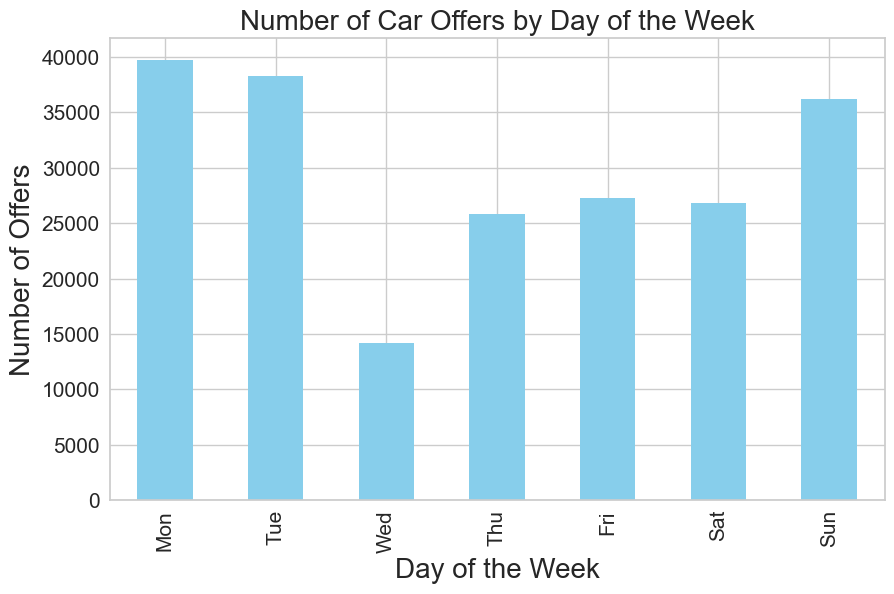

In [73]:
# Analyze the distribution of car offers over time by month, week, and day of the week

# Monthly distribution

# Prepare month names and month indices (1 to 12)
all_months = list(calendar.month_name[1:13])  # Month names from January to December

# Monthly distribution
plt.figure(figsize=(10, 6))
month_counts = car_sale_df['Offer_month'].value_counts().sort_index()

# Ensure all months are plotted (fill missing months with 0)
month_counts_complete = pd.Series(0, index=range(1, 13))  # Initialize all months with 0
month_counts_complete.update(month_counts)  # Update counts with actual values

# Plot with all months
plt.bar(all_months, month_counts_complete ,color='skyblue')
plt.title('Number of Car Offers by Month',fontsize=20)
plt.xlabel('Month',fontsize=20)
plt.ylabel('Number of Offers',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


# Weekly distribution
plt.figure(figsize=(10, 6))
car_sale_df['Offer_week'].value_counts().sort_index().plot(kind='line',color='skyblue')
plt.title('Number of Car Offers by Week',fontsize=20)
plt.xlabel('Week of the Year',fontsize=20)
plt.ylabel('Number of Offers',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

# Day of the week distribution
plt.figure(figsize=(10, 6))
day_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
car_sale_df['Offer_day_of_week'].value_counts().sort_index().plot(kind='bar',color='skyblue')
plt.title('Number of Car Offers by Day of the Week',fontsize=20)
plt.xlabel('Day of the Week',fontsize=20)
plt.ylabel('Number of Offers',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(range(7), day_labels)
plt.show()


In [75]:
car_sale_df_cleaned = car_sale_df[['Offer_publication_date','Offer_month', 'Offer_day', 'Offer_day_of_week',
       'Offer_week']]

In [82]:
# Calculate the value counts for 'Offer_publication_date'
value_counts = car_sale_df['Offer_publication_date'].value_counts().reset_index()
value_counts.columns = ['Offer_publication_date', 'Number of Ads']

# Display the total of counts
total_count = value_counts['Number of Ads'].sum()

# Print the value counts and the total count

print("Total of value counts:", total_count)


# Merge the value counts back into the cleaned dataframe
ads_per_date_df = car_sale_df_cleaned.merge(value_counts, on='Offer_publication_date', how='left')

# Convert to DataFrame for better visualization
ads_per_date_df = ads_per_date_df.reset_index(drop=True)

# Set the 'Offer_publication_date' as the index
ads_per_date_df.set_index('Offer_publication_date', inplace=True)

# Display the first 3 rows for verification
ads_per_date_df.head(3)


Total of value counts: 208304


,Offer_month,Offer_day,Offer_day_of_week,Offer_week,Number of Ads
Offer_publication_date,,,,,
2021-05-04,5,4,1,18,25895
2021-05-03,5,3,0,18,26561
2021-05-03,5,3,0,18,26561


In [84]:
ads_per_date_df = ads_per_date_df.drop_duplicates()

In [92]:
ads_per_date_df.groupby('Offer_day_of_week')['Number of Ads'].sum().reset_index()


,Offer_day_of_week,Number of Ads
0,0,39737
1,1,38332
2,2,14178
3,3,25816
4,4,27252
5,5,26777
6,6,36212


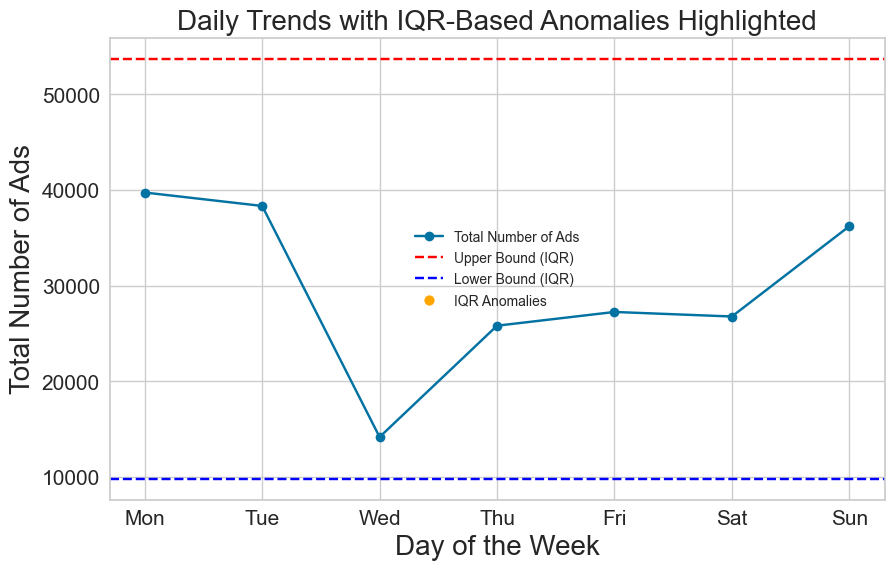

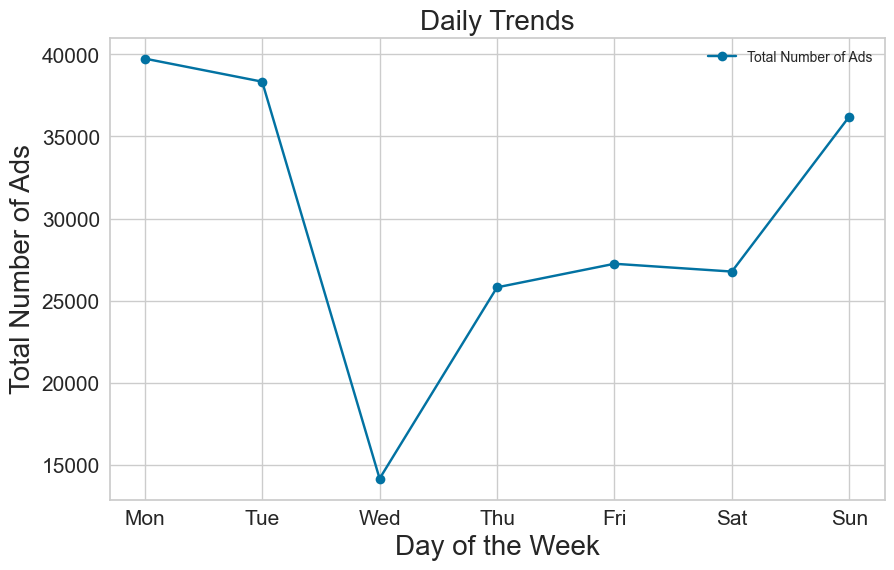

In [97]:
# Calculate the sum of 'Number of Ads' for each day of the week
daily_trend = ads_per_date_df.groupby('Offer_day_of_week')['Number of Ads'].sum().reset_index()

# Calculate the IQR for the weekly average 'Number of Ads'
Q1 = daily_trend['Number of Ads'].quantile(0.25)
Q3 = daily_trend['Number of Ads'].quantile(0.75)
IQR = Q3 - Q1

# Define anomaly thresholds using the IQR method
k = 1.5  # Moderate threshold for detecting outliers
lower_bound = Q1 - k * IQR
upper_bound = Q3 + k * IQR

# Identify anomalies
iqr_anomalies = daily_trend[(daily_trend['Number of Ads'] < lower_bound) | 
                            (daily_trend['Number of Ads'] > upper_bound)]

# Map day indices to day names for x-axis labels
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Plot 1: Daily trends with lower and upper bounds
plt.figure(figsize=(10, 6))
plt.plot(daily_trend['Offer_day_of_week'], daily_trend['Number of Ads'], marker='o', label='Total Number of Ads')
plt.axhline(y=upper_bound, color='red', linestyle='--', label=f'Upper Bound (IQR)')
plt.axhline(y=lower_bound, color='blue', linestyle='--', label=f'Lower Bound (IQR)')
plt.scatter(iqr_anomalies['Offer_day_of_week'], iqr_anomalies['Number of Ads'], color='orange', label='IQR Anomalies', zorder=5)
plt.title('Daily Trends with IQR-Based Anomalies Highlighted', fontsize=20)
plt.xlabel('Day of the Week', fontsize=20)
plt.ylabel('Total Number of Ads', fontsize=20)
plt.xticks(ticks=range(7), labels=day_names, fontsize=15)  # Use day names for x-axis
plt.yticks(fontsize=15)
plt.grid(True)
plt.legend()
plt.show()

# Plot 2: Daily trends without bounds 
plt.figure(figsize=(10, 6))
plt.plot(daily_trend['Offer_day_of_week'], daily_trend['Number of Ads'], marker='o', label='Total Number of Ads')
plt.title('Daily Trends', fontsize=20)
plt.xlabel('Day of the Week', fontsize=20)
plt.ylabel('Total Number of Ads', fontsize=20)
plt.xticks(ticks=range(7), labels=day_names, fontsize=15)  # Use day names for x-axis
plt.yticks(fontsize=15)
plt.grid(True)
plt.legend()
plt.show()


In [95]:
ads_per_date_df.groupby('Offer_month')['Number of Ads'].sum().reset_index()


,Offer_month,Number of Ads
0,3,8
1,4,105033
2,5,103263


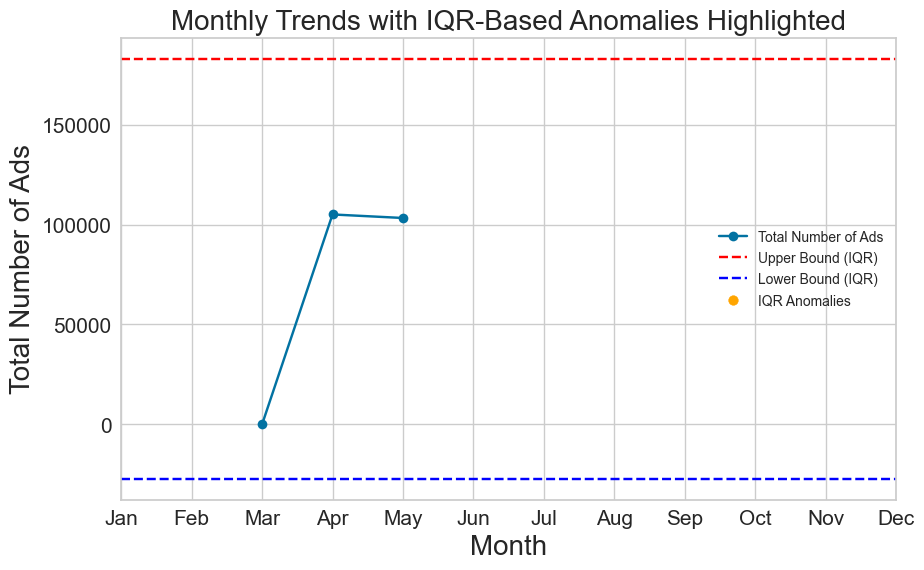

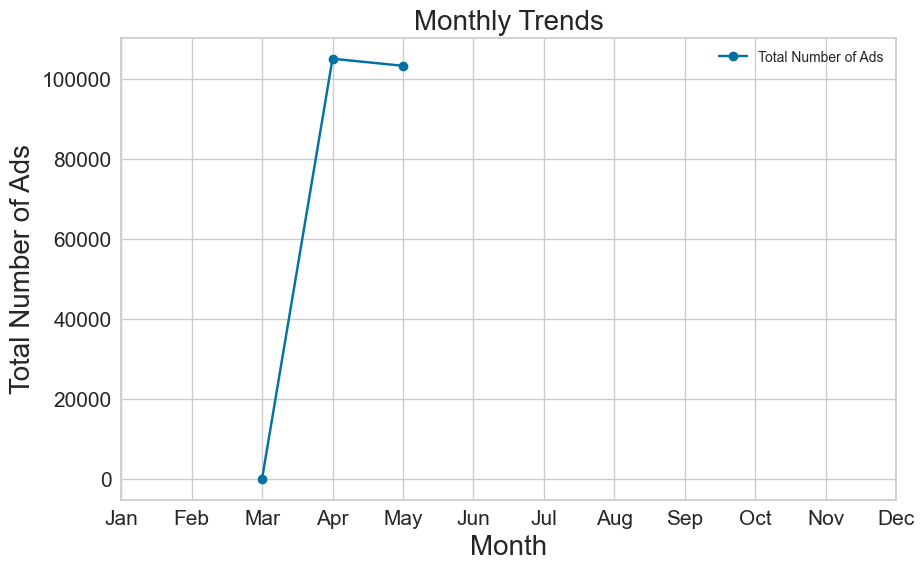

In [98]:
# Calculate the sum of 'Number of Ads' for each month
monthly_trend = ads_per_date_df.groupby('Offer_month')['Number of Ads'].sum().reset_index()

# Calculate the IQR for the monthly average 'Number of Ads'
Q1 = monthly_trend['Number of Ads'].quantile(0.25)
Q3 = monthly_trend['Number of Ads'].quantile(0.75)
IQR = Q3 - Q1

# Define anomaly thresholds using the IQR method
k = 1.5  # Moderate threshold for detecting outliers
lower_bound = Q1 - k * IQR
upper_bound = Q3 + k * IQR

# Identify anomalies
iqr_anomalies = monthly_trend[(monthly_trend['Number of Ads'] < lower_bound) | 
                            (monthly_trend['Number of Ads'] > upper_bound)]

# Map month indices to month names for x-axis labels
month_names = [calendar.month_abbr[i] for i in range(1, 13)]  # Abbreviated month names (Jan, Feb, etc.)

# Plot 1: Monthly trends with lower and upper bounds
plt.figure(figsize=(10, 6))
plt.plot(monthly_trend['Offer_month'], monthly_trend['Number of Ads'], marker='o', label='Total Number of Ads')
plt.axhline(y=upper_bound, color='red', linestyle='--', label=f'Upper Bound (IQR)')
plt.axhline(y=lower_bound, color='blue', linestyle='--', label=f'Lower Bound (IQR)')
plt.scatter(iqr_anomalies['Offer_month'], iqr_anomalies['Number of Ads'], color='orange', label='IQR Anomalies', zorder=5)
plt.title('Monthly Trends with IQR-Based Anomalies Highlighted', fontsize=20)
plt.xlabel('Month', fontsize=20)
plt.ylabel('Total Number of Ads', fontsize=20)
plt.xticks(ticks=range(1, 13), labels=month_names, fontsize=15)  # Correct range for months (1 to 12)
plt.yticks(fontsize=15)
plt.grid(True)
plt.legend()
plt.show()

# Plot 2: Monthly trends without bounds (just the average number of ads)
plt.figure(figsize=(10, 6))
plt.plot(monthly_trend['Offer_month'], monthly_trend['Number of Ads'], marker='o', label='Total Number of Ads')
plt.title('Monthly Trends', fontsize=20)
plt.xlabel('Month', fontsize=20)
plt.ylabel('Total Number of Ads', fontsize=20)
plt.xticks(ticks=range(1, 13), labels=month_names, fontsize=15)  # Correct range for months (1 to 12)
plt.yticks(fontsize=15)
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
ads_per_date_df.groupby('Offer_month')['Number of Ads'].sum().reset_index()

# Calculate the mean of 'Number of Ads' for each week
week_num_trend = ads_per_date_df.groupby('Offer_week')['Number of Ads'].mean().reset_index()

# Calculate the IQR for weekly average 'Number of Ads'
Q1 = week_num_trend['Number of Ads'].quantile(0.25)
Q3 = week_num_trend['Number of Ads'].quantile(0.75)
IQR = Q3 - Q1

# Define anomaly thresholds using the IQR method
k = 1.5  # Moderate threshold for detecting outliers
lower_bound = Q1 - k * IQR
upper_bound = Q3 + k * IQR

# Identify anomalies
iqr_anomalies = week_num_trend[(week_num_trend['Number of Ads'] < lower_bound) | 
                                (week_num_trend['Number of Ads'] > upper_bound)]

# Plot 1: Weekly trends with lower and upper bounds
plt.figure(figsize=(10, 6))
plt.plot(week_num_trend['Offer_week'], week_num_trend['Number of Ads'], marker='o', label='Total Number of Ads')
plt.axhline(y=upper_bound, color='red', linestyle='--', label=f'Upper Bound (IQR)')
plt.axhline(y=lower_bound, color='blue', linestyle='--', label=f'Lower Bound (IQR)')
plt.scatter(iqr_anomalies['Offer_week'], iqr_anomalies['Number of Ads'], color='orange', label='IQR Anomalies', zorder=5)
plt.title('Weekly Trends with IQR-Based Anomalies Highlighted', fontsize=20)
plt.xlabel('Week Number', fontsize=20)
plt.ylabel('Total Number of Ads', fontsize=20)
plt.xticks(ticks=week_num_trend['Offer_week'], fontsize=15)  # Using the actual week numbers on the x-axis
plt.yticks(fontsize=15)
plt.grid(True)
plt.legend()
plt.show()

# Plot 2: Weekly trends without bounds 
plt.figure(figsize=(10, 6))
plt.plot(week_num_trend['Offer_week'], week_num_trend['Number of Ads'], marker='o', label='Total Number of Ads')
plt.title('Weekly Trends', fontsize=20)
plt.xlabel('Week Number', fontsize=20)
plt.ylabel('Total Number of Ads', fontsize=20)
plt.xticks(ticks=week_num_trend['Offer_week'], fontsize=15)  # Using the actual week numbers on the x-axis
plt.yticks(fontsize=15)
plt.grid(True)
plt.legend()
plt.show()


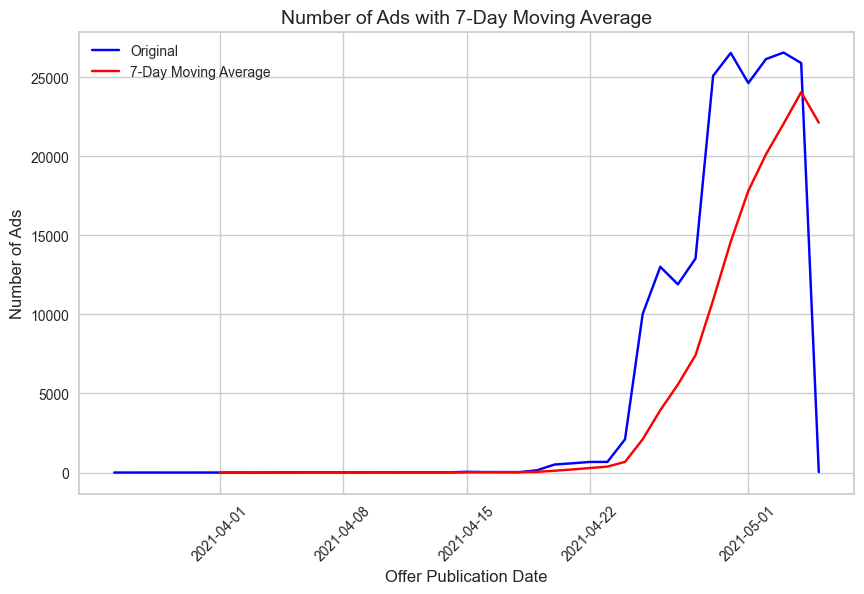

In [101]:
# Aggregate the data by 'Offer_publication_date' (sum or mean the 'Number of Ads')
ads_per_date_aggregated = ads_per_date_df.groupby('Offer_publication_date')['Number of Ads'].sum().reset_index()

# Simple Moving Average (SMA) to smooth the data
ads_per_date_aggregated['SMA'] = ads_per_date_aggregated['Number of Ads'].rolling(window=7).mean()  # 7-day moving average

# Plot the original and smoothed data
plt.figure(figsize=(10, 6))
plt.plot(ads_per_date_aggregated['Offer_publication_date'], ads_per_date_aggregated['Number of Ads'], label='Original', color='blue')
plt.plot(ads_per_date_aggregated['Offer_publication_date'], ads_per_date_aggregated['SMA'], label='7-Day Moving Average', color='red')
plt.legend()
plt.xlabel('Offer Publication Date', fontsize=12)
plt.ylabel('Number of Ads', fontsize=12)
plt.title('Number of Ads with 7-Day Moving Average', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


The total number of ads shows a sharp increase after a certain date, peaking at around 25,000 ads, and then drops quickly.

The trend line confirms a  upward movement or growth in ad publications, likely caused by increased demand, campaigns, or market activity.


there is  cyclical patterns within short intervals.Repeating peaks and troughs suggest regular variations (e.g., weekly or daily patterns) that influence ad posting.

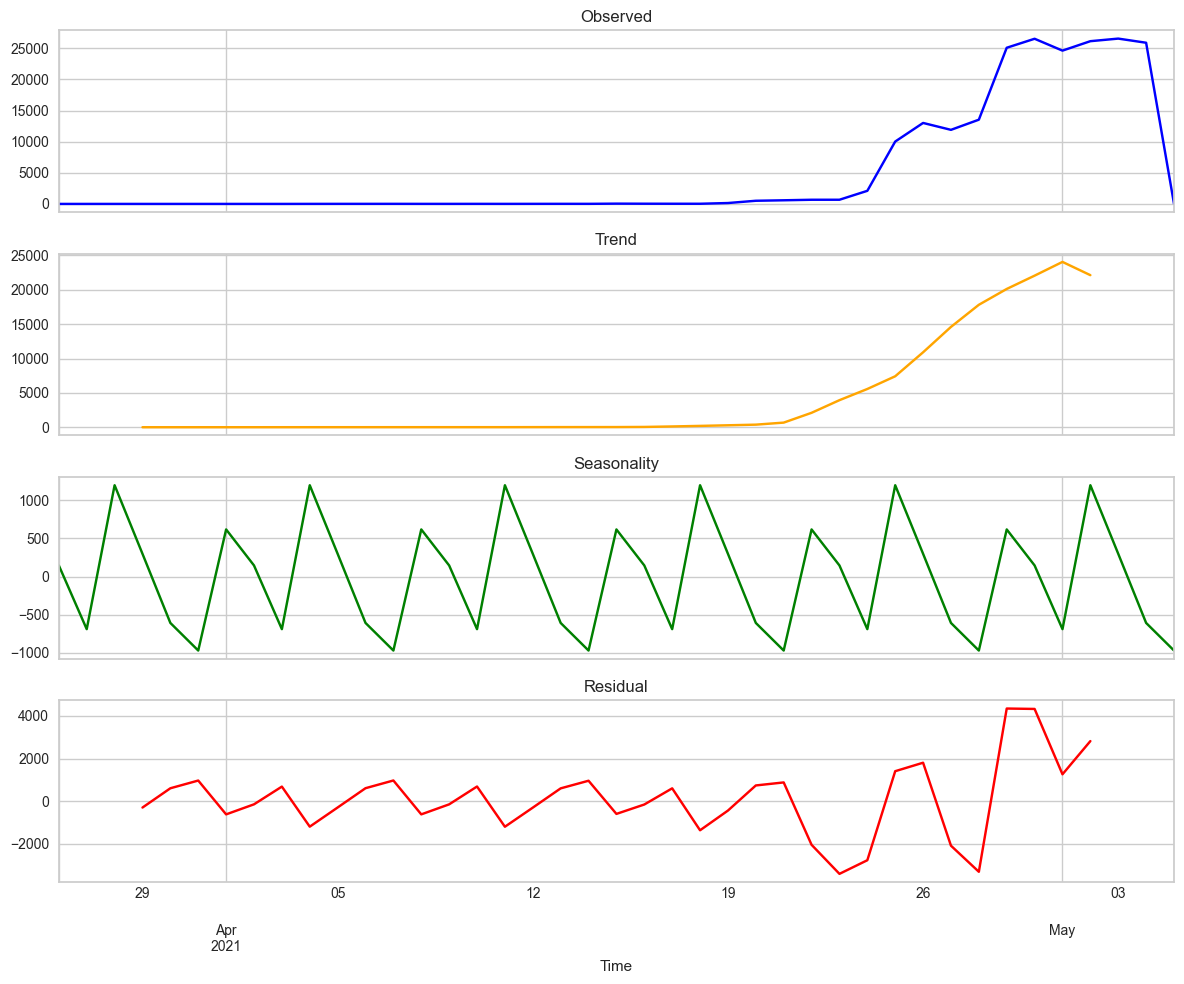

In [102]:

from statsmodels.tsa.seasonal import seasonal_decompose

# Ensure 'Offer_publication_date' is in datetime format
ads_per_date_aggregated['Offer_publication_date'] = pd.to_datetime(ads_per_date_aggregated['Offer_publication_date'])

# Set 'Offer_publication_date' as the index for time series analysis
ads_per_date_aggregated.set_index('Offer_publication_date', inplace=True)

# Perform seasonal decomposition (assuming weekly seasonality for daily data)
decomposed = seasonal_decompose(ads_per_date_aggregated['Number of Ads'], model='additive', period=7)

# Plot the decomposition
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
decomposed.observed.plot(ax=axes[0], title='Observed', color='blue')
decomposed.trend.plot(ax=axes[1], title='Trend', color='orange')
decomposed.seasonal.plot(ax=axes[2], title='Seasonality', color='green')
decomposed.resid.plot(ax=axes[3], title='Residual', color='red')
axes[3].set_xlabel('Time')

plt.tight_layout()
plt.show()


The sharp rise in late April dominates the observed and trend components, possibly caused by an external event (e.g., promotional campaign, external shock, or unplanned demand).

Seasonal Pattern: The data shows a clear periodic structure, likely representing consistent seasonal behavior.

2021-04-25', '2021-05-05

The trend reflects a steady increase starting mid-April.


In [ ]:
#ads_per_date_df['Rolling_Sum'] = ads_per_date_df['Number of Ads'].rolling(window=3).sum()

Modelling

In [143]:
# Before building and training the model, let's split the data into training and testing
df_train, df_test = ads_per_date_df[ads_per_date_df.index < '2021-05-01'], ads_per_date_df[ads_per_date_df.index >= '2021-05-01']

print('Train:\t', len(df_train))
print('Test:\t', len(df_test))

Train:	 36
Test:	 5


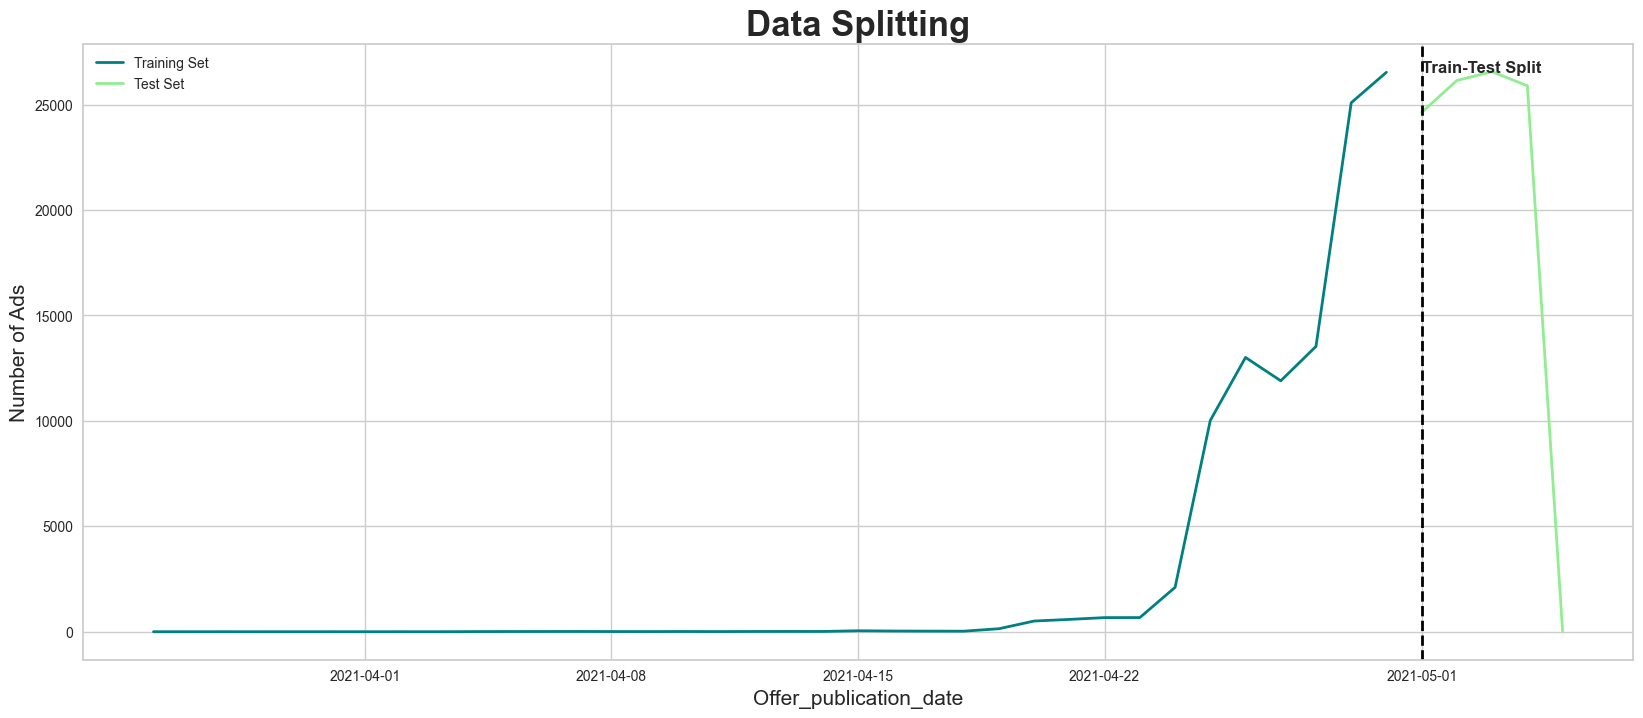

In [145]:
import matplotlib.pyplot as plt

# Ensure the data is sorted by date
df_train = df_train.sort_index()
df_test = df_test.sort_index()

# Plot the train and test sets
plt.figure(figsize=(20, 8))

plt.plot(df_train.index, df_train['Number of Ads'], label='Training Set', color='teal', linewidth=2)
plt.plot(df_test.index, df_test['Number of Ads'], label='Test Set', color='lightgreen', linewidth=2)

# Add a vertical line for the split
split_date = df_test.index.min()
plt.axvline(split_date, color='black', linestyle='--', linewidth=2)
plt.text(split_date, df_train['Number of Ads'].max(), 'Train-Test Split', fontsize=12, fontweight='bold', rotation=0)

# Add title, legend, and axis labels
plt.title('Data Splitting', weight='bold', fontsize=25)
plt.xlabel('Offer_publication_date', fontsize=15)
plt.ylabel('Number of Ads', fontsize=15)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [196]:
df_train = df_train[['Number of Ads']]
df_test = df_test[['Number of Ads']]

In [173]:
def sliding_window (window_size , data):
    windows , labels = [] , []
    for i in range(window_size , len (data)):
        windows.append(data[i-window_size:i , 0])
        labels.append(data[i,0])
    windows , labels = np.array(windows) , np.array(labels) 
    return windows , labels

In [184]:
full_windows , full_labels = sliding_window(window_size = 2, data = num_ad_df.values)
print(full_windows.shape)
print(full_labels.shape)
len(full_windows) ,len(full_labels)   

(39, 2)
(39,)


(39, 39)

In [185]:
split_size = int (len(full_windows)*0.8)
train_windows = full_windows[:split_size]
train_labels = full_labels[:split_size]

test_windows = full_windows[split_size:]
test_labels = full_labels[split_size:]

len(train_windows),len(train_labels),len(test_windows),len(test_labels)

(31, 31, 8, 8)

In [190]:
from tensorflow.keras.layers import Dense, Dropout, LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

# Set seed for reproducibility
tf.random.set_seed(7)

# Define model architecture
model_lstm = Sequential()

# First LSTM layer
model_lstm.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(full_windows.shape[1], 1)))

# Second LSTM layer
model_lstm.add(LSTM(units=128, activation='relu', return_sequences=True))

# Third LSTM layer
model_lstm.add(LSTM(units=128, activation='relu', return_sequences=False))

# Dropout layer to reduce overfitting
model_lstm.add(Dropout(0.2))  # 20% of the neurons will be dropped

# Dense layer for output
model_lstm.add(Dense(units=1))

# Compile model
model_lstm.compile(optimizer='adam', loss='mae', metrics=['mse'])

# EarlyStopping callback to stop training once validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train model
history_lstm = model_lstm.fit(train_windows, train_labels, epochs=50, batch_size=32, 
                              validation_data=(test_windows, test_labels),
                              callbacks=[early_stopping])


Epoch 1/50
1/1 [==============================] - 1s 1s/step - loss: 5018.1567 - mse: 103802664.0000 - val_loss: 5.6067 - val_mse: 127.2777
Epoch 2/50
1/1 [==============================] - 0s 15ms/step - loss: 4986.8062 - mse: 102856192.0000 - val_loss: 5.5954 - val_mse: 127.2100
Epoch 3/50
1/1 [==============================] - 0s 14ms/step - loss: 4976.0122 - mse: 102551528.0000 - val_loss: 5.5841 - val_mse: 127.1421
Epoch 4/50
1/1 [==============================] - 0s 15ms/step - loss: 4969.3525 - mse: 102278408.0000 - val_loss: 5.5723 - val_mse: 127.0722
Epoch 5/50
1/1 [==============================] - 0s 15ms/step - loss: 4944.4238 - mse: 101752904.0000 - val_loss: 5.5598 - val_mse: 126.9989
Epoch 6/50
1/1 [==============================] - 0s 14ms/step - loss: 4924.2817 - mse: 101141840.0000 - val_loss: 5.5461 - val_mse: 126.9200
Epoch 7/50
1/1 [==============================] - 0s 15ms/step - loss: 4914.8975 - mse: 100738872.0000 - val_loss: 5.5310 - val_mse: 126.8357
Epoch 8/

In [191]:
#  evaluate on test data
evaluate_test = model_lstm.evaluate(test_windows,test_labels)
print(f'Mean absolute error  {evaluate_test[0]:.2f}\nMean square error  { round(np.sqrt(evaluate_test[1] )) }')

history_df = pd.DataFrame(history_lstm.history)
history_df.head(5)

1/1 [==============================] - 0s 14ms/step - loss: 5.3242 - mse: 125.5525
Mean absolute error  5.32
Mean square error  11


,loss,mse,val_loss,val_mse
0,"5,018.16","103,802,664.00",5.61,127.28
1,"4,986.81","102,856,192.00",5.60,127.21
2,"4,976.01","102,551,528.00",5.58,127.14
3,"4,969.35","102,278,408.00",5.57,127.07
4,"4,944.42","101,752,904.00",5.56,127.00


In [188]:
evaluate_test

[5.537909984588623, 126.74671936035156]

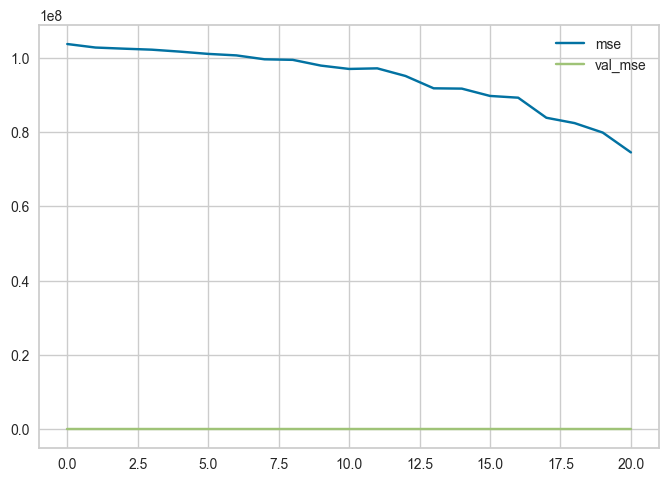

In [192]:
history_df = pd.DataFrame(history_lstm.history)
plt.plot(history_df['mse'],label= 'mse')
plt.plot(history_df['val_mse'] , label ='val_mse')
plt.legend()
plt.show()

As we have information for 40 date, it is wrong to apply LSTM for small dataset. I need to apply more simple model.